## NN language models


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from random import sample
from tqdm import trange

%matplotlib inline

### Подготовка данных

Данные - корпус [ArXiv](http://arxiv.org/) статей с [kaggle](https://www.kaggle.com/neelshah18/arxivdataset/)


In [ ]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2023-05-01 18:14:46--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-05-01 18:14:46--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc72c7eecc9bd63f266d1523c34.dl.dropboxusercontent.com/cd/0/get/B7NjsB_Yw8G_R1I90nO0QTBV2yE2lFlmwKGJg0S8b4ZMNB8fHE2v_wN2wRCg58ltRgCCHsTiSOOPMU-dfahNux2b-rncOikOM9DNR3Bqg8sy0CQg0SHJlsRRBm0OnUfPmnFMABDN7pYEv6HWSctcM9C6Ye5UIIep2tUtf6skt3yjgw/file?dl=1# [following]
--2023-05-01 18:14:46--  https://ucc72c7eecc9bd63f266d1523c34.dl.dropboxusercontent.com/cd/0/get/B7NjsB_Yw8G_R1I90nO0QTBV2yE2lFlmwKGJg0S8b4ZMNB8f

,author,day,id,link,month,summary,tag,title,year
9677,"[{'name': 'Johann A. Bengua'}, {'name': 'Ho N....",15,1609.04541v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",9,This paper introduces matrix product state (MP...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Matrix Product State for Higher-Order Tensor C...,2016
12596,"[{'name': 'Pan Li'}, {'name': 'Qiang Liu'}, {'...",11,1803.03965v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,"In big data era, machine learning is one of fu...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",BEBP: An Poisoning Method Against Machine Lear...,2018
9808,"[{'name': 'Yifei Ma'}, {'name': 'Roman Garnett...",17,1209.3694v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,Many real-world datasets can be represented in...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Submodularity in Batch Active Learning and Sur...,2012
4428,"[{'name': 'Chong Zhang'}, {'name': 'Shaofei Wa...",21,1709.07337v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We study the problem of instance segmentation ...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Efficient Column Generation for Cell Detection...,2017
10726,"[{'name': 'David Duvenaud'}, {'name': 'James R...",20,1302.4922v4,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,"Despite its importance, choosing the structura...","[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Structure Discovery in Nonparametric Regressio...,2013


Нам понадобятся специальные токены:

* Begin Of Sequence  (__BOS__)
* End Of Sequence (__EOS__)


In [ ]:
BOS, EOS = ' ', '\n'

lines = data.apply(
    lambda row: (row['title'] + ' ; ' + row['summary'])[:512],
    axis=1,
).apply(lambda line: BOS + line.replace(EOS, ' ') + EOS).tolist()

In [ ]:
lines[:4]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurre

Дальше построим **char-level vocabulary**

In [ ]:
tokens = list(set([char for word in lines for char in word]))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


Определим каждому символу свой числовой индекс


In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

token_to_id['o']

80

Соберем строки в матрицу `[batch_size, text_length]` и добавим паддинг до `max_len`

In [ ]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [ ]:
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Нейросетевая LM

Как и в случае модели на n-gram'ах мы снова хотим оценить вероятность текста как совместную вероятность токенов (символов)


$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Вместо того, чтобы считать статистики (counts) по корпусу, будет тренировать НС с параметрами $\theta$  для оценки условной вероятности:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$

Для начала возьмем архитектуру с фиксированным окном:

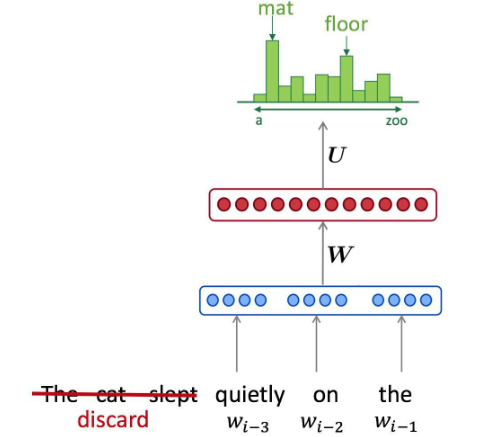


### CNN

![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   


Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$


После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность.

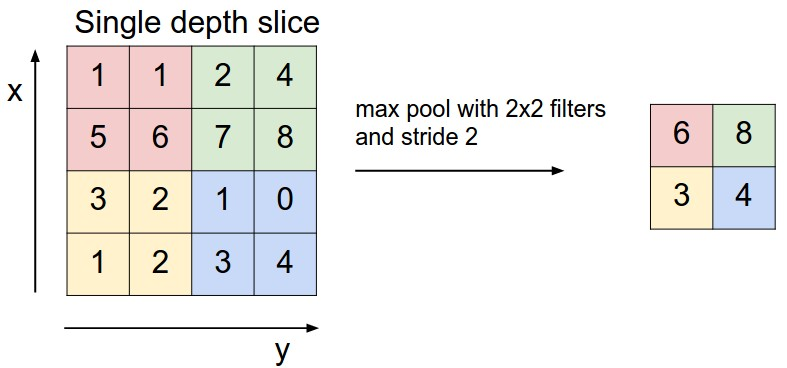

#### CNN для текстов

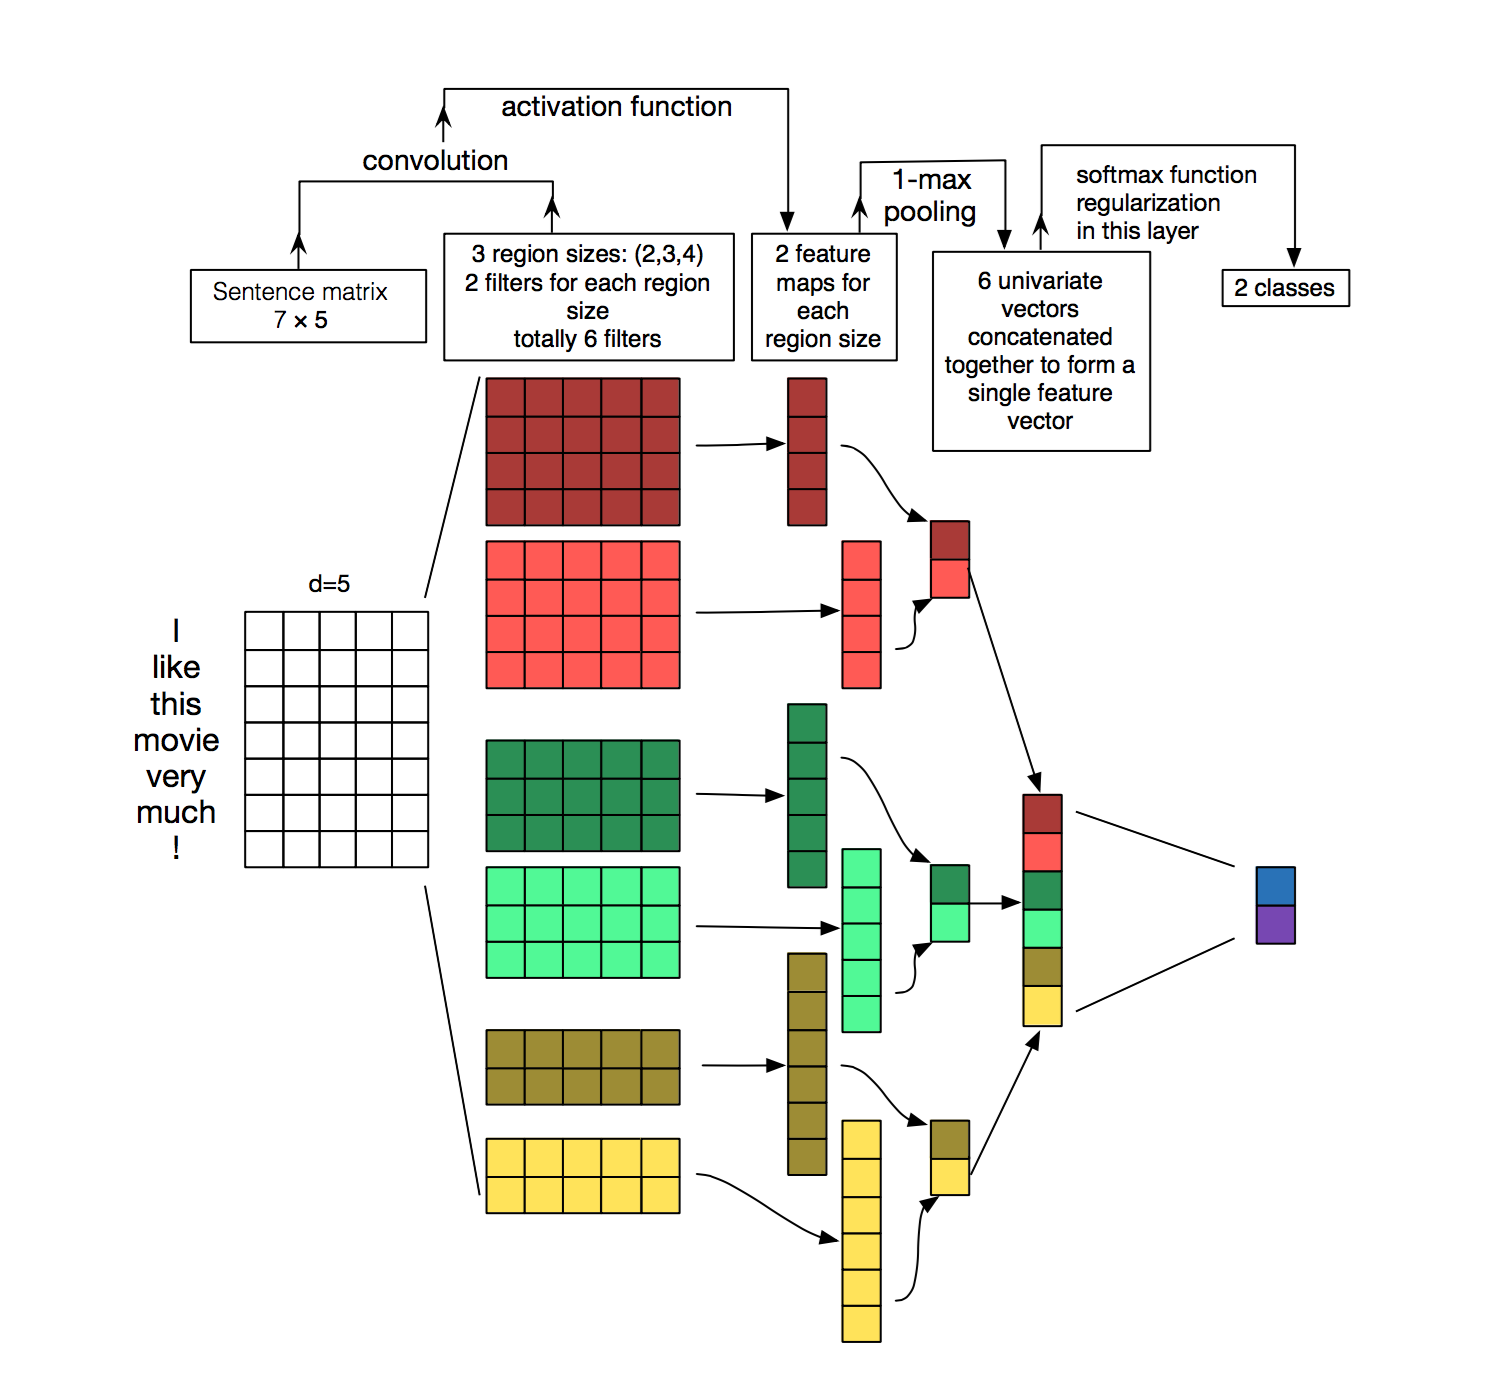

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        """
        super().__init__()

        filter_size = 32
        kernel_size = 5
        stride = 1

        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.padding = nn.ZeroPad2d((stride * (kernel_size - 1), 0, 0, 0)) # left padding
        self.conv_1 = nn.Conv1d(in_channels=emb_size, out_channels=hid_size, kernel_size=kernel_size, stride=stride)
        self.conv_2 = nn.Conv1d(in_channels=hid_size, out_channels=hid_size, kernel_size=kernel_size, stride=stride)
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)


    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        input_ix = torch.as_tensor(input_ix).to(device)
        out = self.embedding(input_ix)
        out = torch.permute(out, (0, 2, 1))
        out = self.conv_1(self.padding(out))
        for _ in range(3):
            out = self.conv_2(self.padding(out))
        out = torch.permute(out, (0, 2, 1))
        out = self.linear(out)
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [ ]:
dummy_model = FixedWindowLanguageModel().to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('embedding.weight', 'conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'linear.weight', 'linear.bias')


Будем минимизировать categorical crossentropy во время обучения на данных $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

Минимизация categorical crossentropy эквивалентная минимизации перплексии

In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [ ]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    mask = compute_mask(input_ix)[:, 1:]
    lengths = mask.sum(-1) - 1 # drop padded
    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    answers = torch.nn.functional.one_hot(reference_answers, num_classes=logits.shape[2])

    loss = torch.sum(
        (torch.logsumexp(logits, dim=2) - torch.sum(logits * answers, dim=2)) * mask
    ) / len(lengths)

    return loss

In [ ]:
dummy_model.to(device)

#### Оценка качества


In [ ]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

#### Training loop


In [ ]:
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_test_every = 250
train_history, test_history = [], []
model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

test_history.append((0, score_lines(model, test_lines, batch_size)))
print("Sample before training:", generate(model, 'NLP is a '))

Sample before training: NLP is a c>:õ?χM{?~qβ!γγqρ}3Jæ$.(/(uNI%Ö&0N?&ïJbś.kIfU7ãs/~ΣãTfβè4wχ[é`1Bd@vDd3kéyTE;J5;őÖ=7Q[ρ ã0íaI


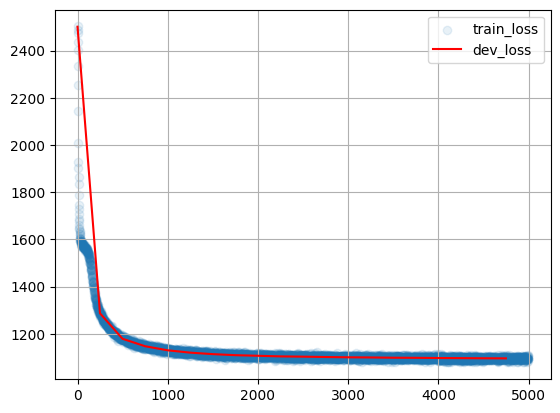

Generated examples (tau=0.5):
 Con biand Explitica na poretiming for mantis ar en and temedel 2019 sis and anderaluze work for Meat
 Ontion the comons tive anderen is bath are camestive work ang he ptroust me thes anconte teal for he
 A porecsing ing of llewith al weres of e the cempora ditare the on dicaling inge and Clating ; The f
Scoring test...


100%|██████████| 5000/5000 [05:14<00:00, 15.92it/s]

#4999 Test loss: 1095.724


In [ ]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(test_history):
            plt.plot(*zip(*test_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_test_every == 0:
        print("Scoring test...")
        test_history.append((i, score_lines(model, test_lines, batch_size)))
        print('#%i Test loss: %.3f' % test_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", test_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1095.7235621903583
 Conting Spare ; We leracins and compurien se forment ion senicling and and exprobes and this der chm
 Compring Reath ing approdent ontorich arnestiment ons ance simale dechion ; We probine we d Somplex 
 Antove Spalerec ite cond are time ras ared the sed for ingoration ina compliare mantich ar bes the t
 The ACACling Somation ; In thes paper, we thot te thes poreat of the forner comprond mathe sestor fo
 Inthor ang the mede rectine for dethen the anderaco the sstice tareathe the se comporace an oralimal
 Buser and Malting ares beve probermation of action ly we for Network prof re the and ard cater al ar
 Entection ar arenily and itare the aptrex male dethe and are cod bation sy pacile cofsemaltist oppor
 Complex-Bayd and Evate the se pored to deasis ant problemations wo ks araper antiog and context on b
 Antering araplorized Mathon thathe mod of thow th the chestic arsed if ra the mathe the revereation 
 Ention ly this copprexintichit the oningal ing

In [ ]:
print(generate(model, prefix='NLP is a ', temperature=0.5))

NLP is a CNNLDPMPRNNL); TANND:2D1) ; Thith iond in the areretion s of latere for anc ure the problima


### RNN

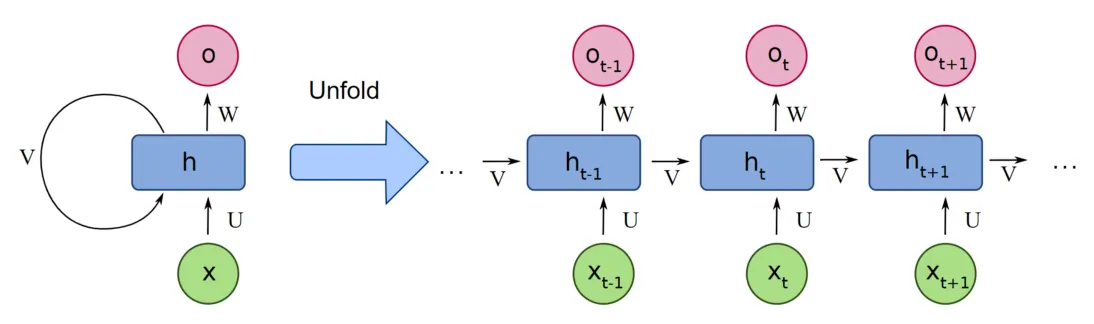

#### RNN LM

Попробуем использовать RNN для LM:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$


Модель обрабатывает по одному токену слева направо, поддерживая скрытое состояние, выучиваемое из токенов

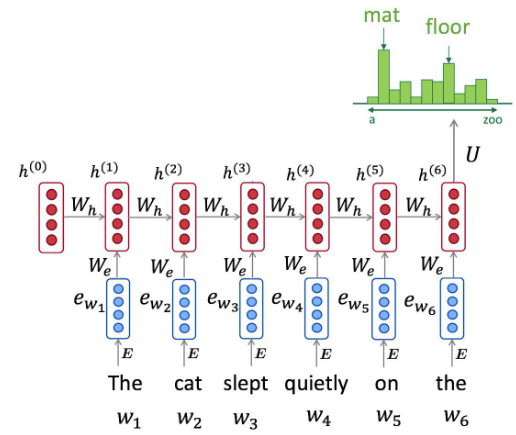

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """
        Build a recurrent language model.
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
        """
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hid_size, batch_first=True)
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        input_ix = torch.as_tensor(input_ix).to(device)
        out = self.embedding(input_ix)
        out, (hn, cn) = self.lstm(out)
        out = self.linear(out)
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [ ]:
model = RNNLanguageModel().to(device)

#### RNN training


In [ ]:
batch_size = 64
score_dev_every = 250
clip_value = 5
train_history, test_history = [], []
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

test_history.append((0, score_lines(model, test_lines, batch_size)))
print("Sample before training:", generate(model, 'NLP is a '))

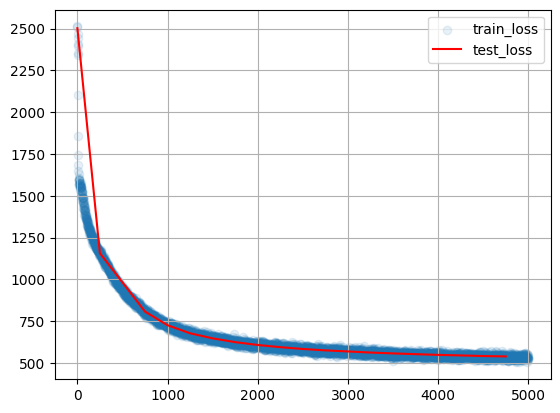

Generated examples (tau=0.5):
 A Component Feature Recognition ; This paper presents a novel key formal selection and recognition o
 Learning to Local Segmentation with Convolutions ; In this paper we present a new structure of this 
 Real-world and finding the Convergence of Chinision ; Many convex and energy is the real world appli
Scoring test...


100%|██████████| 4500/4500 [05:09<00:00, 14.53it/s]

#4999 Test loss: 536.488


In [ ]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(test_history):
            plt.plot(*zip(*test_history), color='red', label='test_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring test...")
        test_history.append((i, score_lines(model, test_lines, batch_size)))
        print('#%i Test loss: %.3f' % test_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", test_history[-1][-1])
for i in range(10):
    print(generate(model, prefix='NLP is a ', temperature=0.5))

Final dev loss: 536.4876510099085
NLP is a formal for a set of a new approach to system from a graph control   and   and machine learni
NLP is a crucial regression of a multi-via paper proposes a new method for multi-computer   and margi
NLP is a set of the extends of this results ; In this paper, we propose a novel approach to the stati
NLP is a structured graph of the State-of-the-art Detection ; We propose a novel optimal transition o
NLP is a convex of statistical models for the subset of the correct a new method for conditional mult
NLP is a Convolutional Neural Network for Improved Components ; We propose a new context of the state
NLP is a fundamental problem of extracting deep neural networks ; Tensors that are complex of the seq
NLP is a computer vision of the distance control for multi-specific segmentation ; The most complexit
NLP is a binary detection of a deep neural network ; Recently, the state-of-the-art matching is a com
NLP is a process of different topic for short st

### Еще о сэмплировании

До сих пор мы сэплировали токены в соответствии с их вероятностями, однако здесь могут возникнуть проблемы, связанные с тем что softmax по определению не выдает нулевые вероятностии, и мы можем получить бессмысленные токены в ответе.

Температура отчасти решает эту проблему, но низкая температура вредит разнообразию генерации. Попробуем рассмотреть другие стратегии генерации



#### Nucleus Sampling (ядерное сэмплирование)

похожая идея на топ-k сэмплирование, но $k$ теперь выбирается динамически. В ядерном сэмплировании мы сэмплируем из top-__N%__ вероятностного распределения.

Например, при вероятностях токенов $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ и N=0.89, сэмплированные токены выглядят как:
1. наиболее вероятный токен $w_2$, так как $p(w_2) < N$
2. второй наиболее вероятный токен $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. третий наиболее вероятный токен $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

И на этом все, так как добавление любого следующего токена переполнит возможное предельное значение (N): $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

После выбора токенов ядерным сэмплированием, необходимо нормализовать их и сэмплировать следующий токен


In [ ]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleus  always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)
        probs_sort = (-1 * probs).argsort()

        count = 0
        tokens_ids = []
        while nucleus >= 0:
            tokens_ids.append(probs_sort[count])
            nucleus -= probs[probs_sort[count]]
            count += 1

        probs[tokens_ids] = 0
        probs /= sum(probs)
        next_token = next_token = np.random.choice(tokens, p=probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
for n in np.linspace(0.1, 0.9, 9):
    print(f"nucleus value: {np.round(n, 2)}, text: {generate_nucleus(model, prefix='NLP is a ', nucleus=n)}")

nucleus value: 0.1, text: NLP is a general doron-devices in   language has analyzed ; In has become a framework for automated s
nucleus value: 0.2, text: NLP is a Comparative Priditional field of SRRE Deep Neural Networks ; LSGE inverse (Examprigation and
nucleus value: 0.3, text: NLP is a Plan Tratfer: Videl Selection in Deep Suating-have   Actor Operatoom ; In this paper, we pro
nucleus value: 0.4, text: NLP is a 3D supervised Alabaten Module Brain Analysis ; Data span

nucleus value: 0.5, text: NLP is a two-detection of binary  for hyperpatient methods ; Which exist evidences which can be varia
nucleus value: 0.6, text: NLP is a taking to study growing not deep convolutional todess ; Unlabeled models are focused search,
nucleus value: 0.7, text: NLP is a Vary notion of but modifiers on ideas of multi-regression process with perspective, ; Neurom
nucleus value: 0.8, text: NLP is a 3un Algorithm for Markers From Soman-Gaussian Programming ; Within a two representation of t
nucleus val

#### Beam Search (лучевой поиск)

Иногда нам не нужно, чтобы модель генерировала разнообразные результаты, так как вмы хотим получить один лучший вариант с учетом префикса.

Чтобы найти наиболее вероятную последовательность, содержащую 10 токенов,  нужно будет проверить все $|V|^{10}$ возможных гипотез. Однако можно найти приблизительный наиболее вероятный результат с помощью **beam search**.

Как это работает:
0. Инициализируем `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` генерируем все возможные токены для всех гипотез в beam, `len(beam) * len(vocab)` кандидатов
3. ` ... ` выбираем `beam_size` лучших кандидатов как новый `beam`
4. Выбираем лучшую гипотезу из beam

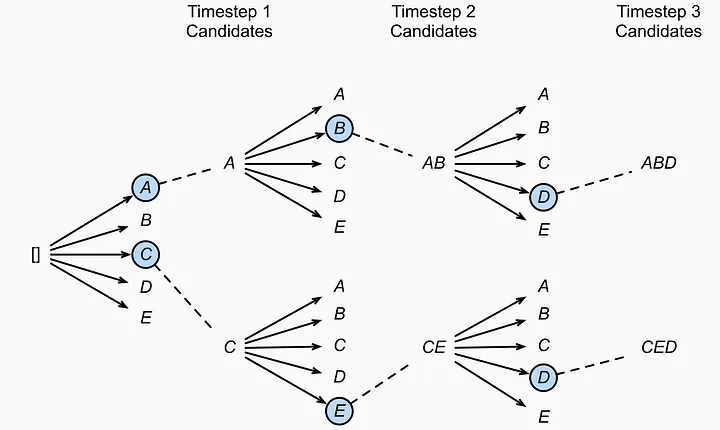

[PyTorch-Beam-Search](https://github.com/budzianowski/PyTorch-Beam-Search-Decoding) - PyTorch implementation of beam search decoding for seq2seq models

#### Сбалансированное Min-p сэмплирование

[Turning Up the Heat: Min-p Sampling for Creative and Coherent LLM Outputs](https://arxiv.org/abs/2407.01082)

1. Выбирается токен с наибольшей вероятностью — $P_{max}$;

2. Гиперпараметр метода — базовый порог вероятности, $P_{base}$ (авторы рекомендуют выбирать между 0,05 и 0,1) — умножается на $P_{max}$, и получается порог отсечки — $P_{scaled}$. По нему отсекаются токены, всё, что ниже, выкидывается;

3. Формируется пул для семплирования из оставшихся токенов;

4. Вероятности нормализуются.

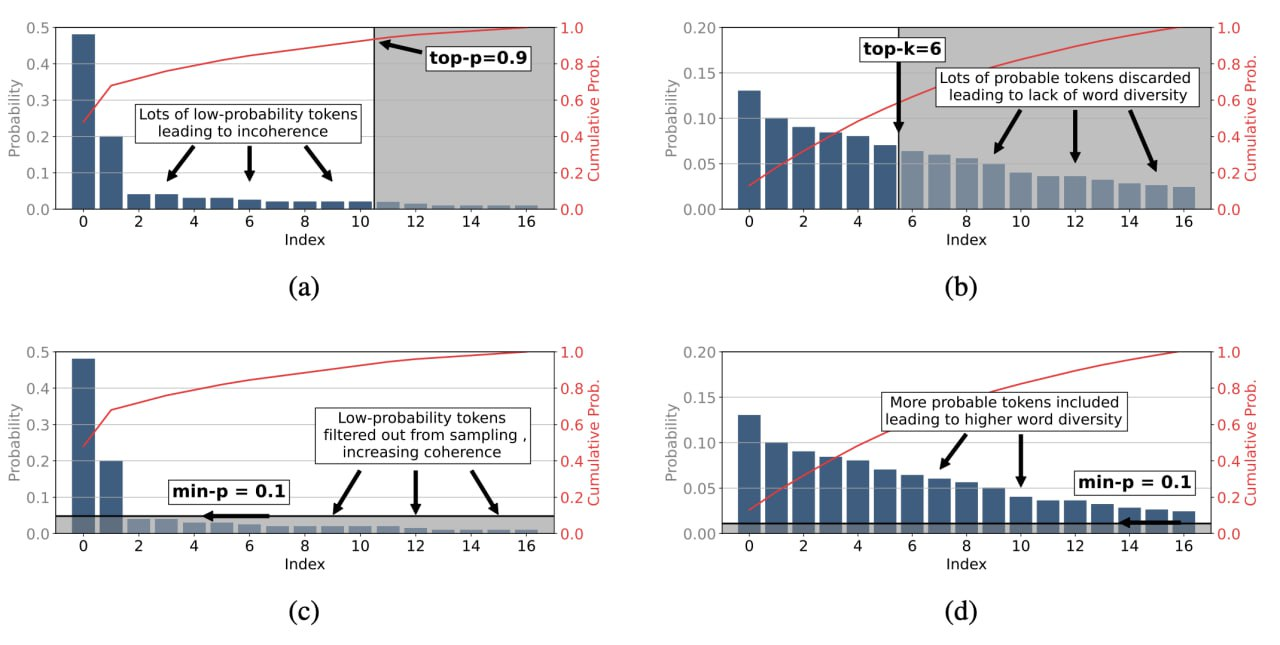